# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第24节 比特币 vs 黄金 ？莱特币 vs 白银 ？</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook:](https://github.com/bbfamily/abu/abupy_lecture)

之前的几节做的全部是ump相关的回测与训练，本节将在第10节:比特币莱特币的回测, 第12节:机器学习与比特币示例, 第14节:量化相关性分析应用的基础上做一个完整的比特币策略示例。

首先导入abupy中本节使用的模块：

In [2]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
%matplotlib inline

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [3]:
from abupy import AbuFuturesCn, AbuFuturesGB, ABuSymbolPd, ABuCorrcoef, ECoreCorrType, EMarketDataFetchMode
from abupy import ECoreCorrType, EMarketTargetType, find_similar_with_se, ABuScalerUtil, abu, ABuProgress
from abupy import AbuProgress, AbuMetricsBase, EDataCacheType, ml, AbuFactorSellNDay

### 1. 比特币 vs 黄金 ？莱特币 vs 白银 ？

在第14节中使用abupy中的各个相似度接口示例了如何度量相关性。

比特币与莱特币是现在交易量最大的币类，比特币的出现类似于真实市场中的黄金，莱特币的设计标榜黄金与白银的关系，比特币10分钟一个块，莱特币参照1：4的关系设计2.5分钟一个块，总数量比特币为2100万，莱特币8400万，那是不是比特币和黄金的相关度高，莱特币和白银的相关度高呢？

下面首先从内置期货symbol数据中查到国内期货黄金，白银的code：

In [4]:
fcn = AbuFuturesCn()
fcn.futures_cn_df[(fcn.futures_cn_df['product'] == '黄金') | 
                  (fcn.futures_cn_df['product'] == '白银')]

,symbol,product,min_deposit,min_unit,commission,exchange
36,AU0,黄金,0.06,1000,10.0,SHFE
40,AG0,白银,0.08,15,10.0,SHFE


接下来从内置期货symbol数据中查到国际期货黄金，白银的code：

In [5]:
fgb = AbuFuturesGB()
fgb.futures_gb_df[(fgb.futures_gb_df['product'] == '伦敦金') | (fgb.futures_gb_df['product'] == '伦敦银') |  
                  (fgb.futures_gb_df['product'] == '纽约黄金') | (fgb.futures_gb_df['product'] == '纽约白银')]

,symbol,product,min_deposit,min_unit,exchange
6,XAU,伦敦金,0.10,1,LME
7,XAG,伦敦银,0.10,100,LME
15,SI,纽约白银,0.08,5000,NYMEX
16,GC,纽约黄金,0.08,100,NYMEX


将上述期货黄金，白银产品和比特币，莱特币一起做交易数据获取，如下：

In [6]:
choice_symbols = ['btc', 'ltc', 'AU0', 'AG0', 'XAU', 'XAG', 'SI', 'GC']
panel = ABuSymbolPd.make_kl_df(choice_symbols, start='2014-03-19', end='2017-07-25',
                               show_progress=True)
# 转换panel轴方向，即可方便获取所有金融时间数据的某一个列
panel = panel.swapaxes('items', 'minor')
# dropna：因为btc, ltc一周交易7天，别的市场5天，dropna即把周六，周日的都drop了
cg_df = panel['p_change'].dropna()
cg_df.tail()

pid:90376 _make_kl_df complete:100.0%
pid:90376 done!


,AG0,AU0,GC,SI,XAG,XAU,btc,ltc
2017-07-19,0.260,0.128,-0.081,-0.062,0.055,-0.150,0.879,-4.374
2017-07-20,-0.155,0.055,0.242,0.308,0.387,0.418,9.022,4.762
2017-07-21,0.753,0.584,0.892,1.227,0.575,0.491,4.624,0.900
2017-07-24,-0.052,0.236,0.024,-0.242,0.255,0.266,0.095,-0.749
2017-07-25,0.206,0.127,-0.446,0.061,0.018,-0.315,-3.353,-2.734


只使用正负号相关度计算，如下所示：

备注：更多关于相关性的接口使用请阅读 第14节:量化相关性分析应用

In [7]:
corr_df = ABuCorrcoef.corr_matrix(cg_df, similar_type=ECoreCorrType.E_CORE_TYPE_SIGN)
corr_df.btc.sort_values()[::-1]

btc    1.0000
ltc    0.5929
AG0    0.0457
AU0    0.0321
GC     0.0304
SI     0.0130
XAU    0.0099
XAG    0.0026
Name: btc, dtype: float64

从结果可以看到，和比特币最相关的是国内白银，并不是黄金，而且国内期货相关性要高于国际期货产品。

但从结果来看实际上并不知道黄金，白银在整体市场中与比特币的相关水平，下面以整个A股市场和比特币做相关性计算，统计相关值。


### 2. A股市场和比特币的相关性

下面运行的代码需要在运行完成第19节 数据源 相关数据获取后才可以运行：

In [8]:
# 关闭沙盒数据
abupy.env.disable_example_env_ipython()

disable example env


关闭沙盒数据，需要运行下载了第19节中的各个全市场数据，由于hdf5文件解压后非常大，还需要区分python版本，而且python2还分了市场，所以建议使用csv格式的缓存文件。

[csv格式美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1geNZgqf) 密码: gvtr

下面根据下载的数据缓存类型设置缓存类型，如果下载解压的是csv需要勾选use_csv，如果是hdf5不需要勾选：

In [10]:
# 将数据读取模式设置为本地数据模式，即进行全市场回测时最合适的模式，运行效率高，且分类数据更新和交易回测。
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL
def select_store_cache(use_csv):
    if use_csv:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    else:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_HDF5
    print(abupy.env.g_data_cache_type)
        
use_csv = ipywidgets.Checkbox(True)
_ = ipywidgets.interact(select_store_cache, use_csv=use_csv)

EDataCacheType.E_DATA_CACHE_CSV


下面使用正负号(涨跌)相关计算比特币和a股市场中所有股票的相关性，如下：

[('btc', 1.0), ('sz000721', 0.14443010567929634), ('sh600165', 0.13993970793663504), ('sh600694', 0.13540920479269), ('sh600710', 0.13512182508336076), ('sh600069', 0.1260842656032366), ('sz000601', 0.12433233281880053), ('sz002151', 0.11976673729850321), ('sh600493', 0.11935961851421031), ('sz002003', 0.11847511669660844)]


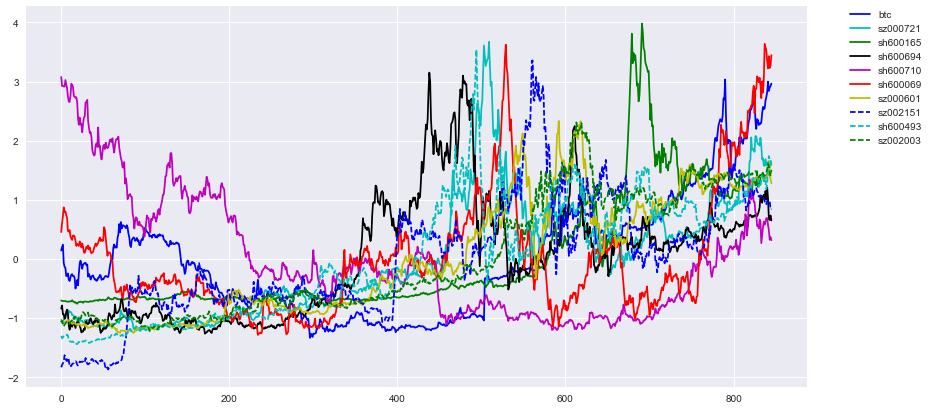

In [15]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
similar_a = find_similar_with_se('btc', start='2013-09-01', end='2016-08-08', corr_type=ECoreCorrType.E_CORE_TYPE_SIGN)

将结果使用DataFrame进行包装, 如下：

In [16]:
similar_a_pd = pd.DataFrame(similar_a, columns=['symbol', 'sim'])
similar_a_pd.head()

,symbol,sim
0,btc,1.0000
1,sz000721,0.1444
2,sh600165,0.1399
3,sh600694,0.1354
4,sh600710,0.1351


首先统计一下A股所有股票与比特币相关性的平均值，可以看到平均结果在0.035左右，则上面期货黄金，白银与比特币的相关度也就大概这个水平，并不高，如下 ：

In [17]:
similar_a_pd.sim.mean()

0.03572812069028136

先用qcut统计一下相关度的平均各个级，如下：

In [19]:
pd.qcut(similar_a_pd.sim, 10).value_counts()

(0.0736, 1]            249
(0.0438, 0.0518]       249
(0.0197, 0.0288]       249
[-0.0826, -0.00495]    249
(0.0606, 0.0736]       248
(0.0518, 0.0606]       248
(0.0362, 0.0438]       248
(0.0288, 0.0362]       248
(0.00928, 0.0197]      248
(-0.00495, 0.00928]    248
Name: sim, dtype: int64

大概算出bin的阀值，使用cut bins的方式进行统计，如下所示：

In [20]:
pd.cut(similar_a_pd.sim, bins=[-np.inf, -0.03, 0.1, np.inf]).value_counts()

(-0.03, 0.1]     2391
(0.1, inf]         47
(-inf, -0.03]      46
Name: sim, dtype: int64

可以看到A股市场中与比特币正相关的值比较高，所以如下要大概选取100个a股市场中与比特币最相关的只选取正相关的，如下：

In [24]:
similar_a_top = similar_a_pd[(similar_a_pd.sim > 0.088)].iloc[2:]
# 添加个投票方向在下面的示例策略中会使用
similar_a_top['vote_direction'] = np.where(similar_a_top.sim > 0, 1, -1)
print(similar_a_top.shape)
similar_a_top.head()

(98, 3)


,symbol,sim,vote_direction
2,sh600165,0.1399,1
3,sh600694,0.1354,1
4,sh600710,0.1351,1
5,sh600069,0.1261,1
6,sz000601,0.1243,1


### 3. 比特币综合实战交易当日策略

上面找到了和比特币最相关的100个A股市场股票，编写一个比特币日交易策略，如下：

1. 买入条件1: 当日这100个股票60%以上都是上涨的
2. 买入条件2: 使用在第12节：机器学习与比特币示例中编写的：信号发出今天比特币会有大行情

下面先构造一个在第12节：机器学习与比特币示例中使用的BtcBigWaveClf对象，如下所示：

start grid search please wait...


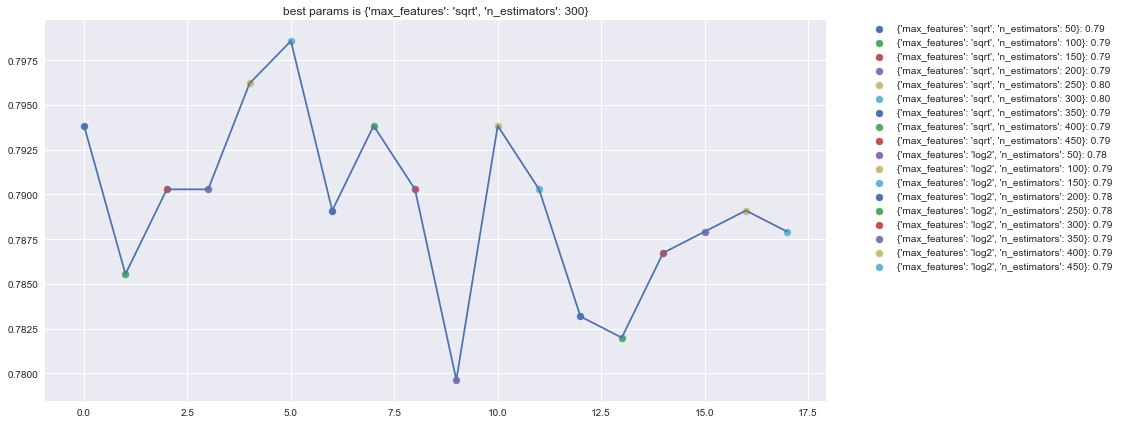

In [29]:
# 只取到2016-08-08，保留一年的数据做回测使用
btc = ABuSymbolPd.make_kl_df('btc', start='2013-09-01', end='2016-08-08')
btc_ml = ml.BtcBigWaveClf(btc=btc)
param_grid = {'max_features': ['sqrt', 'log2'], 'n_estimators': np.arange(50, 500, 50)}
btc_ml.random_forest_classifier_best(param_grid=param_grid)
_ = btc_ml.fit()

下面开始写择时策略AbuBTCDayBuy，如下：

In [38]:
from abupy import AbuFactorBuyBase, BuyCallMixin

class AbuBTCDayBuy(AbuFactorBuyBase, BuyCallMixin):
    def _init_self(self, **kwargs):
        # 市场中与btc最相关的top个股票
        self.btc_similar_top = kwargs.pop('btc_similar_top')
        # 超过多少个相关股票今天趋势相同就买入
        self.btc_vote_val = kwargs.pop('btc_vote_val', 0.60)

        def _collect_kl(sim_line):
            """在初始化中将所有相关股票的对应时间的k线数据进行收集"""
            start = self.kl_pd.iloc[0].date
            end = self.kl_pd.iloc[-1].date
            kl = ABuSymbolPd.make_kl_df(sim_line.symbol, start=start, end=end)
            self.kl_dict[sim_line.symbol] = kl

        self.kl_dict = {}
        # k线数据进行收集到类字典对象self.kl_dict中
        self.btc_similar_top.apply(_collect_kl, axis=1)

    def fit_day(self, today):
        """
        :param today: 当前驱动的交易日金融时间序列数据
        :return:
        """
        # 忽略不符合买入的天（统计周期内前两天, 因为btc的机器学习特证需要三天交易数据）
        if self.today_ind < 2:
            return None

        # 今天，昨天，前天三天的交易数据进行特证转换
        btc = self.kl_pd[self.today_ind - 2:self.today_ind + 1]
        # 三天的交易数据进行转换后得到btc_today_x
        btc_today_x = self.make_btc_today(btc)

        # btc_ml并没有在这里传入，实际如果要使用，需要对外部的btc_ml进行本地序列化后，构造读取本地
        # 买入条件2: 使用在第12节：机器学习与比特币示例中编写的：信号发出今天比特币会有大行情
        if btc_ml.predict(btc_today_x):
            # 买入条件1: 当日这100个股票60%以上都是上涨的
            vote_val = self.similar_predict(today.date)
            if vote_val > self.btc_vote_val:
                # 没有使用当天交易日的close等数据，且btc_ml判断的大波动是当日，所以当日买入
                return self.buy_today()
            
    def make_btc_today(self, sib_btc):
        """构造比特币三天数据特证"""
        sib_btc['big_wave'] = (sib_btc.high - sib_btc.low) / sib_btc.pre_close > 0.55
        sib_btc['big_wave'] = sib_btc['big_wave'].astype(int)
        sib_btc_scale = ABuScalerUtil.scaler_std(
            sib_btc.filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                            'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14']))
        # 把标准化后的和big_wave，date_week连接起来
        sib_btc_scale = pd.concat([sib_btc['big_wave'], sib_btc_scale, sib_btc['date_week']], axis=1)

        # 抽取第一天，第二天的大多数特征分别改名字以one，two为特征前缀，如：one_open，one_close，two_ma5，two_high.....
        a0 = sib_btc_scale.iloc[0].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a0.rename(index={'open': 'one_open', 'close': 'one_close', 'high': 'one_high', 'low': 'one_low',
                         'volume': 'one_volume', 'pre_close': 'one_pre_close',
                         'ma5': 'one_ma5', 'ma10': 'one_ma10', 'ma21': 'one_ma21',
                         'ma60': 'one_ma60', 'atr21': 'one_atr21', 'atr14': 'one_atr14',
                         'date_week': 'one_date_week'}, inplace=True)

        a1 = sib_btc_scale.iloc[1].filter(['open', 'close', 'high', 'low', 'volume', 'pre_close',
                                           'ma5', 'ma10', 'ma21', 'ma60', 'atr21', 'atr14', 'date_week'])
        a1.rename(index={'open': 'two_open', 'close': 'two_close', 'high': 'two_high', 'low': 'two_low',
                         'volume': 'two_volume', 'pre_close': 'two_pre_close',
                         'ma5': 'two_ma5', 'ma10': 'two_ma10', 'ma21': 'two_ma21',
                         'ma60': 'two_ma60', 'atr21': 'two_atr21', 'atr14': 'two_atr14',
                         'date_week': 'two_date_week'}, inplace=True)
        # 第三天的特征只使用'open', 'low', 'pre_close', 'date_week'，该名前缀today，如today_open，today_date_week
        a2 = sib_btc_scale.iloc[2].filter(['big_wave', 'open', 'low', 'pre_close', 'date_week'])
        a2.rename(index={'open': 'today_open', 'low': 'today_low',
                         'pre_close': 'today_pre_close',
                         'date_week': 'today_date_week'}, inplace=True)
        # 将抽取改名字后的特征连接起来组合成为一条新数据，即3天的交易数据特征－>1条新的数据
        btc_today = pd.DataFrame(pd.concat([a0, a1, a2], axis=0)).T

        # 开始将周几进行离散处理
        dummies_week_col = btc_ml.df.filter(regex='(^one_date_week_|^two_date_week_|^today_date_week_)').columns
        dummies_week_df = pd.DataFrame(np.zeros((1, len(dummies_week_col))), columns=dummies_week_col)

        # 手动修改每一天的one hot
        one_day_key = 'one_date_week_{}'.format(btc_today.one_date_week.values[0])
        dummies_week_df[one_day_key] = 1
        two_day_key = 'two_date_week_{}'.format(btc_today.two_date_week.values[0])
        dummies_week_df[two_day_key] = 1
        today_day_key = 'today_date_week_{}'.format(btc_today.today_date_week.values[0])
        dummies_week_df[today_day_key] = 1
        btc_today.drop(['one_date_week', 'two_date_week', 'today_date_week'], inplace=True, axis=1)
        btc_today = pd.concat([btc_today, dummies_week_df], axis=1)
        return btc_today.as_matrix()[:, 1:]

    def similar_predict(self, today_date):
        """与比特币在市场中最相关的top100个股票已各自今天的涨跌结果进行投票"""
        def _predict_vote(sim_line, _today_date):
            kl = self.kl_dict[sim_line.symbol]
            if kl is None:
                return -1 * sim_line.vote_direction > 0
            kl_today = kl[kl.date == _today_date]
            if kl_today is None or kl_today.empty:
                return -1 * sim_line.vote_direction > 0
            # 需要 * sim_line.vote_direction，因为负相关的存在
            return kl_today.p_change.values[0] * sim_line.vote_direction > 0

        vote_result = self.btc_similar_top.apply(_predict_vote, axis=1, args={today_date, })
        # 将所有投票结果进行统计，得到与比特币最相关的这top100个股票的今天投票结果
        vote_val = 1 - vote_result.value_counts()[False] / vote_result.value_counts().sum()
        return vote_val

上面编写的AbuBTCDayBuy即完成了在预测今天比特币有大行情，且今天与比特币最相关的市场是涨势的择时策略：

* 注意上面的比特币交易为当日交易，因为比特币是24小时交易，可以当天a股闭市后获取数据进行实盘策略，也可以a股开盘涨跌稳定后获取数据进行实盘策略，也可以错开市场交易时间，比如之后会示例使用美股市场的最相关的top100，由于美股是晚上进行交易，即可错开时间

下面构造买入因子和卖出因子，买入因子构造AbuBTCDayBuy使用similar_a_top，即a股最相关的top100个做为参数传入，卖出因子使用AbuFactorSellNDay其为简单卖出策略，买入后持有sell_n天后不管结果如何就卖出，下面的参数sell_n=1, 即买入后第二天就卖出，如下：

In [39]:
buy_factors = [{'btc_similar_top':similar_a_top,
                'class': AbuBTCDayBuy}]
sell_factors = [{'class': AbuFactorSellNDay, 'sell_n': 1}]

# 设置市场类型为币类
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_TC
#买入因子，卖出因子等依然使用相同的设置，如下所示：
read_cash = 1000000
abupy.beta.atr.g_atr_pos_base = 0.5

下面开始使用2016-08-09至2017-08-08做为回测时间段，如下：

pid:40420 pick times complete:100.0%
pid:40420 done!0.0%


买入后卖出的交易数量:32
买入后尚未卖出的交易数量:1
胜率:65.6250%
平均获利期望:4.9695%
平均亏损期望:-5.4895%
盈亏比:1.8675
所有交易收益比例和:0.4397 
所有交易总盈亏和:273980.2900 


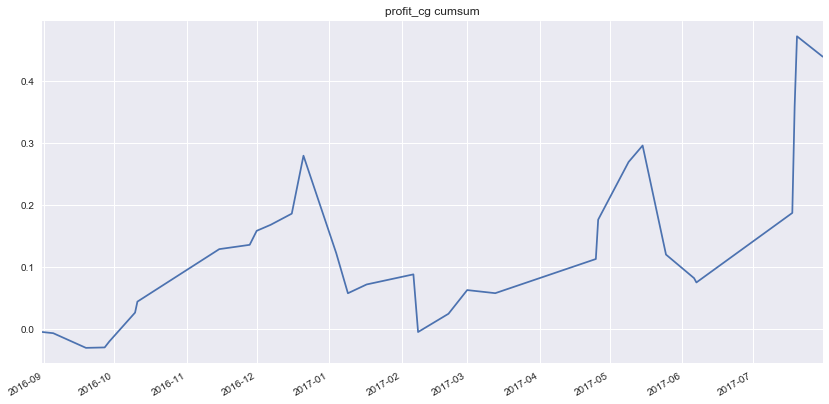

In [40]:
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2016-08-09',
                                                   end='2017-08-08',
                                                   choice_symbols=['btc'], n_process_pick=1)
AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=True)

上面的结果可以看到胜率可以达到65%，盈亏比也比较高，由于使用a股市场的top100个做为相关性策略参数对象，比特币是24小时交易，所以可以当天a股闭市后获取数据进行实盘策略，也可以a股开盘涨跌稳定后（开盘两个小时后）获取数据进行实盘策略，也可以使用其它市场的参数，下面示例使用美股市场的最相关的top100，由于美股是晚上进行交易，即可错开时间。

### 4. 美股市场和比特币的相关性

和a股市场类似，首先使用find_similar_with_se进行整个美股市场与比特币的相关性计算，如下：

[('btc', 1.0), ('usFCX', 0.10793671297095597), ('usNRT', 0.10592038167853511), ('usJPI', 0.099381902834822414), ('usJAKK', 0.099191766375118562), ('usPOST', 0.098432427960305227), ('usPFBI', 0.098061032693774697), ('usMCO', 0.09300617875802053), ('usBDJ', 0.092161388048609946), ('usTGLS', 0.091788054368066321)]


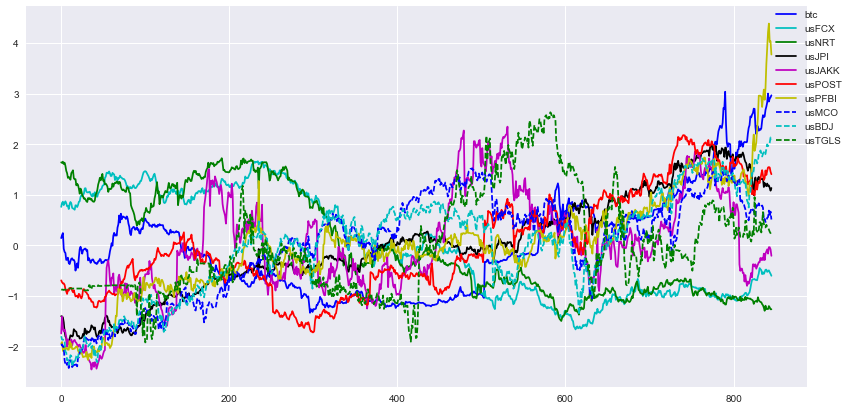

,symbol,sim
0,btc,1.0000
1,usFCX,0.1079
2,usNRT,0.1059
3,usJPI,0.0994
4,usJAKK,0.0992


In [41]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
similar_us = find_similar_with_se('btc', start='2013-09-01', end='2016-08-08', corr_type=ECoreCorrType.E_CORE_TYPE_SIGN)
similar_us_pd = pd.DataFrame(similar_us, columns=['symbol', 'sim'])
similar_us_pd.head()

使用qcut可以明显看到和A股市场不同，美股市场中存在一定数量与比特币负相关值比较高的symbol：

In [45]:
pd.qcut(similar_us_pd.sim, 10).value_counts()

(0.0457, 1]            359
(0.0311, 0.0457]       359
(0.021, 0.0311]        359
(0.0124, 0.021]        359
(0.00438, 0.0124]      359
(-0.00366, 0.00438]    359
(-0.0128, -0.00366]    359
(-0.023, -0.0128]      359
(-0.0364, -0.023]      359
[-0.0942, -0.0364]     359
Name: sim, dtype: int64

同样再使用cut找到正负相关性最高的top100，与a股市场不同，美股市场同时使用了正相关和负相关，如下：

In [46]:
pd.cut(similar_us_pd.sim, bins=[-np.inf, -0.072, 0.072, np.inf]).value_counts()

(-0.072, 0.072]    3498
(0.072, inf]         61
(-inf, -0.072]       31
Name: sim, dtype: int64

从下面可以看到vote_direction的值根据相关性的正负设定了方向，在AbuBTCDayBuy策略中会根据这个方向做投票方向统计：

In [50]:
sim_us_top = similar_us_pd[(similar_us_pd.sim > 0.071) | (similar_us_pd.sim < -0.070)].iloc[2:]
sim_us_top['vote_direction'] = np.where(sim_us_top.sim > 0, 1, -1)
pd.options.display.max_rows = 6
sim_us_top

,symbol,sim,vote_direction
2,usNRT,0.1059,1
3,usJPI,0.0994,1
4,usJAKK,0.0992,1
...,...,...,...
3587,usMNOV,-0.0933,-1
3588,usSHBI,-0.0936,-1
3589,usECYT,-0.0942,-1


与a股市场类似，下面使用AbuBTCDayBuy进行回测，不同点是使用美股市场的top100做为相关参数，如下：

pid:40420 pick times complete:100.0%
pid:40420 done!0.0%


买入后卖出的交易数量:10
买入后尚未卖出的交易数量:0
胜率:80.0000%
平均获利期望:3.4277%
平均亏损期望:-1.1879%
盈亏比:12.0171
所有交易收益比例和:0.2505 
所有交易总盈亏和:176233.9300 


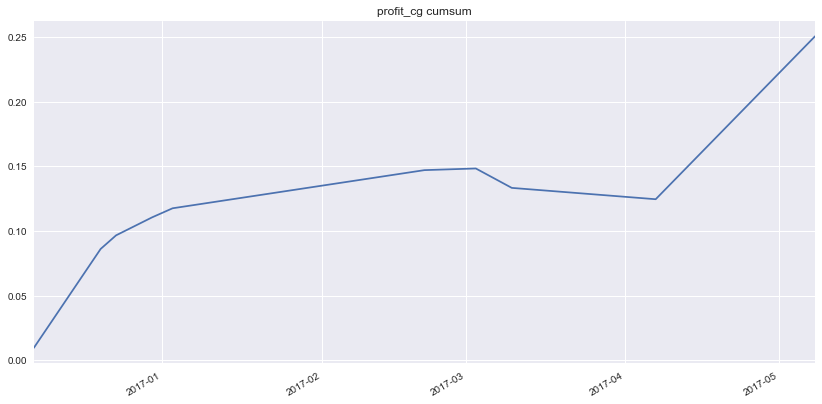

In [44]:
# 设置市场类型为港股
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_TC
buy_factors = [{'btc_similar_top': sim_us_top, 'btc_vote_val': 0.55, 'class': AbuBTCDayBuy}]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2016-08-09',
                                                   end='2017-08-08',
                                                   choice_symbols=['btc'], n_process_pick=1)
AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=True)

上面结果可以看到胜率达到80%，但是成交的数量并不多，在实盘中可以并行多个小策略进行择时，本节使用的数据还是日线级别的数据，所以策略的设计受到很多限制，盈利的能力也有限，在之后的章节将使用分钟级别的时间，策略会不断升级，将比特币这个策略进行不断完善优化，敬请关注公众号的代码以及教程更新提醒。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant


![](./image/qrcode.jpg)